# 1. Importing modules and functions

In [3]:
import numpy as np
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
import chembl_structure_pipeline
from molvs import standardize_smiles
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import joblib
import pickle
from numpy import savetxt
from padelpy import from_sdf
from IPython.display import HTML
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')

[02:53:28] Initializing Normalizer


# 2.Data entry and curation work set

In [4]:
uploaded_file_ws="datasets/HDAC3_work.sdf"
supplier_ws = Chem.ForwardSDMolSupplier(uploaded_file_ws,sanitize=False)
failed_mols_ws = []
all_mols_ws =[]
wrong_structure_ws=[]
wrong_smiles_ws=[]
y_tr = []
y_bad_index=[]

for i, m in enumerate(supplier_ws):
    structure = Chem.Mol(m)
    all_mols_ws.append(structure)
    y_tr.append(m.GetProp("pchembl_value_mean"))
    try:
        Chem.SanitizeMol(structure)
    except:
        failed_mols_ws.append(m)
        wrong_smiles_ws.append(Chem.MolToSmiles(m))
        wrong_structure_ws.append(str(i+1))
        y_bad_index.append(i)
print('Original data: ', len(all_mols_ws), 'molecules')
print('Failed data: ', len(failed_mols_ws), 'molecules')
number_ws =[]
for i in range(len(failed_mols_ws)):
        number_ws.append(str(i+1))
bad_molecules_ws = pd.DataFrame({'No. failed molecule in original set': wrong_structure_ws, 'SMILES of wrong structure: ': wrong_smiles_ws, 'No.': number_ws}, index=None)
bad_molecules_ws = bad_molecules_ws.set_index('No.')
bad_molecules_ws

Original data:  1400 molecules
Failed data:  0 molecules


,No. failed molecule in original set,SMILES of wrong structure:
No.,,


deleting activity values for substances with incorrect structure

In [5]:
y_tr[:] = [x for i,x in enumerate(y_tr) if i not in y_bad_index]

In [6]:
len(y_tr)

1400

# 3.Standardization SDF file for work set

In [7]:
all_mols_ws[:] = [x for i,x in enumerate(all_mols_ws) if i not in y_bad_index] 
records = []
for i in range(len(all_mols_ws)):
    record = Chem.MolToSmiles(all_mols_ws[i])
    records.append(record)

moldf_ws = []
for i,record in enumerate(records):
    standard_record = standardize_smiles(record)
    m = Chem.MolFromSmiles(standard_record)
    moldf_ws.append(m)
    
print('Kept data: ', len(moldf_ws), 'molecules')

Kept data:  1400 molecules


In [6]:
moldf_ws=pd.DataFrame(moldf_ws, columns=['Mol'])
moldf_ws

,Mol
0,<rdkit.Chem.rdchem.Mol object at 0x000001FA538...
1,<rdkit.Chem.rdchem.Mol object at 0x000001FA10A...
2,<rdkit.Chem.rdchem.Mol object at 0x000001FA538...
3,<rdkit.Chem.rdchem.Mol object at 0x000001FA538...
4,<rdkit.Chem.rdchem.Mol object at 0x000001FA538...
...,...
1395,<rdkit.Chem.rdchem.Mol object at 0x000001FA558...
1396,<rdkit.Chem.rdchem.Mol object at 0x000001FA558...
1397,<rdkit.Chem.rdchem.Mol object at 0x000001FA558...
1398,<rdkit.Chem.rdchem.Mol object at 0x000001FA558...


# 4.Data entry and curation test set

In [7]:
uploaded_file_ts="datasets/HDAC3_test.sdf"
supplier_ts = Chem.ForwardSDMolSupplier(uploaded_file_ts,sanitize=False)
failed_mols_ts = []
all_mols_ts =[]
wrong_structure_ts=[]
wrong_smiles_ts=[]
y_ts = []
y_bad_index=[]
for i, m in enumerate(supplier_ts):
    structure = Chem.Mol(m)
    all_mols_ts.append(structure)
    y_ts.append(m.GetProp("pchembl_value_mean"))
    try:
        Chem.SanitizeMol(structure)
    except:
        failed_mols_ts.append(m)
        wrong_smiles_ts.append(Chem.MolToSmiles(m))
        wrong_structure_ts.append(str(i+1))
        y_bad_index.append(i)
print('Original data: ', len(all_mols_ts), 'molecules')
print('Failed data: ', len(failed_mols_ts), 'molecules')
number_ts =[]
for i in range(len(failed_mols_ts)):
        number_ts.append(str(i+1))
bad_molecules_ts = pd.DataFrame({'No. failed molecule in original set': wrong_structure_ts, 'SMILES of wrong structure: ': wrong_smiles_ts, 'No.': number_ts}, index=None)
bad_molecules_ts = bad_molecules_ts.set_index('No.')
bad_molecules_ts

Original data:  351 molecules
Failed data:  0 molecules


,No. failed molecule in original set,SMILES of wrong structure:
No.,,


deleting activity values for substances with incorrect structure

In [8]:
y_ts[:] = [x for i,x in enumerate(y_ts) if i not in y_bad_index]

In [9]:
len(y_ts)

351

# 5.Standardization SDF file for test set

In [10]:
all_mols_ts[:] = [x for i,x in enumerate(all_mols_ts) if i not in y_bad_index] 
records = []
for i in range(len(all_mols_ts)):
    record = Chem.MolToSmiles(all_mols_ts[i])
    records.append(record)

moldf_ts = []
for i,record in enumerate(records):
    standard_record = standardize_smiles(record)
    m = Chem.MolFromSmiles(standard_record)
    moldf_ts.append(m)
    
print('Kept data: ', len(moldf_ts), 'molecules')

Kept data:  351 molecules


In [11]:
moldf_ts=pd.DataFrame(moldf_ts, columns=['Mol'])
moldf_ts

,Mol
0,<rdkit.Chem.rdchem.Mol object at 0x000001FA538...
1,<rdkit.Chem.rdchem.Mol object at 0x000001FA538...
2,<rdkit.Chem.rdchem.Mol object at 0x000001FA538...
3,<rdkit.Chem.rdchem.Mol object at 0x000001FA538...
4,<rdkit.Chem.rdchem.Mol object at 0x000001FA538...
...,...
346,<rdkit.Chem.rdchem.Mol object at 0x000001FA538...
347,<rdkit.Chem.rdchem.Mol object at 0x000001FA538...
348,<rdkit.Chem.rdchem.Mol object at 0x000001FA538...
349,<rdkit.Chem.rdchem.Mol object at 0x000001FA538...


# 6.Calculation MorganFingerprint for work set

In [12]:
def calcfp(mol,funcFPInfo=dict(radius=2, nBits=1024, useFeatures=False, useChirality=False)):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, **funcFPInfo)
    fp = pd.Series(np.asarray(fp))
    fp = fp.add_prefix('Bit_')
    return fp

# Training set
desc_ws = moldf_ws.Mol.apply(calcfp)
desc_ws

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1396,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1397,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1398,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [13]:
y_tr = np.array(y_tr, dtype=np.float32)
len(y_tr)

1400

# 7.Calculation MorganFingerprint for test set

In [14]:
desc_ts = moldf_ts.Mol.apply(calcfp)
desc_ts

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
347,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
348,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
349,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [16]:
y_ts = np.array(y_ts, dtype=np.float32)

# BASELINE

 ## GradientBoostingRegressor model building and validation

In [22]:
seed = 42

In [23]:
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [24]:
estimator = GradientBoostingRegressor(learning_rate=0.01,subsample= 0.5, n_estimators=1000, max_depth= 10,  random_state=seed)

In [19]:
estimator.fit(desc_ws, y_tr)

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000,
                          random_state=42, subsample=0.5)

In [20]:
y_pred_CV_GBR = cross_val_predict(estimator, desc_ws, y_tr, cv=cv, n_jobs=-1)

In [21]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.69

In [22]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.68

# VarianceThreshold

In [17]:
from sklearn.feature_selection import VarianceThreshold

In [18]:
def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [19]:
x_tr_const_and_nearcont=variance_threshold_selector(desc_ws, 0.05)
x_tr_const_and_nearcont

,Bit_1,Bit_4,Bit_8,Bit_14,Bit_15,Bit_25,Bit_31,Bit_33,Bit_36,Bit_41,...,Bit_967,Bit_971,Bit_980,Bit_997,Bit_999,Bit_1009,Bit_1010,Bit_1016,Bit_1017,Bit_1019
0,1,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,1,0,0,0,0,0,0,1,1,0,...,0,1,0,1,0,0,1,1,0,1
1396,1,0,0,0,0,0,0,1,1,0,...,0,1,0,1,0,0,1,1,0,1
1397,1,0,0,0,0,0,0,1,1,0,...,0,1,0,1,0,0,1,1,0,1
1398,1,1,1,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1


In [25]:
estimator.fit(x_tr_const_and_nearcont, y_tr)

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000,
                          random_state=42, subsample=0.5)

In [26]:
y_pred_CV_GBR = cross_val_predict(estimator, x_tr_const_and_nearcont, y_tr, cv=cv, n_jobs=-1)

In [27]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.7

In [28]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.67

# Removing highly correlated features

In [29]:
cor_df = x_tr_const_and_nearcont.corr().abs()
cor_df

,Bit_1,Bit_4,Bit_8,Bit_14,Bit_15,Bit_25,Bit_31,Bit_33,Bit_36,Bit_41,...,Bit_967,Bit_971,Bit_980,Bit_997,Bit_999,Bit_1009,Bit_1010,Bit_1016,Bit_1017,Bit_1019
Bit_1,1.000000,0.023343,0.060250,0.009891,0.011247,0.051526,0.056199,0.309418,0.204014,0.181086,...,0.111018,0.466243,0.044719,0.087555,0.194876,0.077911,0.311692,0.403763,0.021016,0.351924
Bit_4,0.023343,1.000000,0.027675,0.014926,0.037057,0.026979,0.016688,0.129453,0.123931,0.068172,...,0.079457,0.007767,0.014474,0.081022,0.017261,0.042160,0.065133,0.001191,0.028612,0.185722
Bit_8,0.060250,0.027675,1.000000,0.221732,0.042426,0.127507,0.114649,0.072877,0.168621,0.345448,...,0.158420,0.014074,0.089367,0.061572,0.364084,0.142961,0.153835,0.123936,0.095435,0.185521
Bit_14,0.009891,0.014926,0.221732,1.000000,0.070198,0.036017,0.057341,0.065951,0.071944,0.050997,...,0.077259,0.068002,0.088052,0.069185,0.086880,0.029150,0.072931,0.069101,0.029323,0.024528
Bit_15,0.011247,0.037057,0.042426,0.070198,1.000000,0.026488,0.101954,0.021461,0.008593,0.030356,...,0.075230,0.048196,0.158765,0.048643,0.004722,0.053132,0.059986,0.067215,0.083452,0.009351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bit_1009,0.077911,0.042160,0.142961,0.029150,0.053132,0.669497,0.724743,0.031466,0.005697,0.145736,...,0.003805,0.090313,0.006980,0.007684,0.077589,1.000000,0.021332,0.079413,0.382081,0.104191
Bit_1010,0.311692,0.065133,0.153835,0.072931,0.059986,0.003054,0.042885,0.226246,0.460361,0.145991,...,0.077332,0.486556,0.045322,0.187867,0.144834,0.021332,1.000000,0.750003,0.003429,0.272967
Bit_1016,0.403763,0.001191,0.123936,0.069101,0.067215,0.069502,0.025609,0.222045,0.515797,0.216998,...,0.075580,0.642871,0.047347,0.196146,0.128637,0.079413,0.750003,1.000000,0.015121,0.416002
Bit_1017,0.021016,0.028612,0.095435,0.029323,0.083452,0.202189,0.361635,0.070850,0.023592,0.096186,...,0.010623,0.018075,0.021782,0.012167,0.033495,0.382081,0.003429,0.015121,1.000000,0.027988


In [30]:
cor_df = x_tr_const_and_nearcont.corr().abs()
cor_df

,Bit_1,Bit_4,Bit_8,Bit_14,Bit_15,Bit_25,Bit_31,Bit_33,Bit_36,Bit_41,...,Bit_967,Bit_971,Bit_980,Bit_997,Bit_999,Bit_1009,Bit_1010,Bit_1016,Bit_1017,Bit_1019
Bit_1,1.000000,0.023343,0.060250,0.009891,0.011247,0.051526,0.056199,0.309418,0.204014,0.181086,...,0.111018,0.466243,0.044719,0.087555,0.194876,0.077911,0.311692,0.403763,0.021016,0.351924
Bit_4,0.023343,1.000000,0.027675,0.014926,0.037057,0.026979,0.016688,0.129453,0.123931,0.068172,...,0.079457,0.007767,0.014474,0.081022,0.017261,0.042160,0.065133,0.001191,0.028612,0.185722
Bit_8,0.060250,0.027675,1.000000,0.221732,0.042426,0.127507,0.114649,0.072877,0.168621,0.345448,...,0.158420,0.014074,0.089367,0.061572,0.364084,0.142961,0.153835,0.123936,0.095435,0.185521
Bit_14,0.009891,0.014926,0.221732,1.000000,0.070198,0.036017,0.057341,0.065951,0.071944,0.050997,...,0.077259,0.068002,0.088052,0.069185,0.086880,0.029150,0.072931,0.069101,0.029323,0.024528
Bit_15,0.011247,0.037057,0.042426,0.070198,1.000000,0.026488,0.101954,0.021461,0.008593,0.030356,...,0.075230,0.048196,0.158765,0.048643,0.004722,0.053132,0.059986,0.067215,0.083452,0.009351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bit_1009,0.077911,0.042160,0.142961,0.029150,0.053132,0.669497,0.724743,0.031466,0.005697,0.145736,...,0.003805,0.090313,0.006980,0.007684,0.077589,1.000000,0.021332,0.079413,0.382081,0.104191
Bit_1010,0.311692,0.065133,0.153835,0.072931,0.059986,0.003054,0.042885,0.226246,0.460361,0.145991,...,0.077332,0.486556,0.045322,0.187867,0.144834,0.021332,1.000000,0.750003,0.003429,0.272967
Bit_1016,0.403763,0.001191,0.123936,0.069101,0.067215,0.069502,0.025609,0.222045,0.515797,0.216998,...,0.075580,0.642871,0.047347,0.196146,0.128637,0.079413,0.750003,1.000000,0.015121,0.416002
Bit_1017,0.021016,0.028612,0.095435,0.029323,0.083452,0.202189,0.361635,0.070850,0.023592,0.096186,...,0.010623,0.018075,0.021782,0.012167,0.033495,0.382081,0.003429,0.015121,1.000000,0.027988


In [31]:
mask=np.triu(np.ones_like(cor_df, dtype=bool))

In [32]:
tri_df=cor_df.mask(mask)
tri_df

,Bit_1,Bit_4,Bit_8,Bit_14,Bit_15,Bit_25,Bit_31,Bit_33,Bit_36,Bit_41,...,Bit_967,Bit_971,Bit_980,Bit_997,Bit_999,Bit_1009,Bit_1010,Bit_1016,Bit_1017,Bit_1019
Bit_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bit_4,0.023343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bit_8,0.060250,0.027675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bit_14,0.009891,0.014926,0.221732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bit_15,0.011247,0.037057,0.042426,0.070198,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bit_1009,0.077911,0.042160,0.142961,0.029150,0.053132,0.669497,0.724743,0.031466,0.005697,0.145736,...,0.003805,0.090313,0.006980,0.007684,0.077589,NaN,NaN,NaN,NaN,NaN
Bit_1010,0.311692,0.065133,0.153835,0.072931,0.059986,0.003054,0.042885,0.226246,0.460361,0.145991,...,0.077332,0.486556,0.045322,0.187867,0.144834,0.021332,NaN,NaN,NaN,NaN
Bit_1016,0.403763,0.001191,0.123936,0.069101,0.067215,0.069502,0.025609,0.222045,0.515797,0.216998,...,0.075580,0.642871,0.047347,0.196146,0.128637,0.079413,0.750003,NaN,NaN,NaN
Bit_1017,0.021016,0.028612,0.095435,0.029323,0.083452,0.202189,0.361635,0.070850,0.023592,0.096186,...,0.010623,0.018075,0.021782,0.012167,0.033495,0.382081,0.003429,0.015121,NaN,NaN


In [33]:
to_drop=[c for c in tri_df.columns if any(tri_df[c]>0.95) ]
to_drop

['Bit_109', 'Bit_238', 'Bit_331', 'Bit_607']

In [63]:
reduced_df_cor=x_tr_const_and_nearcont.drop(to_drop, axis=1)

In [64]:
reduced_df_cor

,Bit_1,Bit_4,Bit_8,Bit_14,Bit_15,Bit_25,Bit_31,Bit_33,Bit_36,Bit_41,...,Bit_967,Bit_971,Bit_980,Bit_997,Bit_999,Bit_1009,Bit_1010,Bit_1016,Bit_1017,Bit_1019
0,1,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,1,0,0,0,0,0,0,1,1,0,...,0,1,0,1,0,0,1,1,0,1
1396,1,0,0,0,0,0,0,1,1,0,...,0,1,0,1,0,0,1,1,0,1
1397,1,0,0,0,0,0,0,1,1,0,...,0,1,0,1,0,0,1,1,0,1
1398,1,1,1,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1


In [36]:
estimator.fit(reduced_df_cor, y_tr)

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000,
                          random_state=42, subsample=0.5)

In [37]:
y_pred_CV_GBR = cross_val_predict(estimator, reduced_df_cor, y_tr, cv=cv, n_jobs=-1)

In [38]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.7

In [39]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.67

In [40]:
feature_name_reduced_df_cor = reduced_df_cor.columns.tolist()
len(feature_name_reduced_df_cor)

205

# Prediction for test set's molecules

In [41]:
x_ts=desc_ts[feature_name_reduced_df_cor]

In [42]:
y_ts = np.array(y_ts, dtype=np.float32)

In [43]:
y_pred_GBR = estimator.predict(x_ts)

In [44]:
Q2_TS = round(r2_score(y_ts, y_pred_GBR), 2)
Q2_TS

0.71

In [45]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_GBR)), 2)
RMSE_TS

0.66

# save the model to disk

In [46]:
pickle.dump(estimator, open('Models/Morgan_FP/GBR_after_cross_corr_Morgan_FP.pkl', 'wb'))

# load the model from disk

In [47]:
GBR_after_cross_corr_Morgan_FP = pickle.load(open('Models/Morgan_FP/GBR_after_cross_corr_Morgan_FP.pkl', 'rb'))

# Permutation-importance

In [799]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel

In [834]:
sel = SelectFromModel(PermutationImportance(GradientBoostingRegressor(), cv=cv),threshold=0.005,).fit(reduced_df_cor, y_tr)

In [835]:
X_permut_import = sel.transform(reduced_df_cor)
X_permut_import.shape

(1400, 33)

In [836]:
feature_idx = sel.get_support()
feature_name = reduced_df_cor.columns[feature_idx]
feature_name 

Index(['Bit_36', 'Bit_90', 'Bit_117', 'Bit_119', 'Bit_128', 'Bit_197',
       'Bit_229', 'Bit_243', 'Bit_250', 'Bit_301', 'Bit_389', 'Bit_408',
       'Bit_419', 'Bit_486', 'Bit_494', 'Bit_511', 'Bit_549', 'Bit_559',
       'Bit_638', 'Bit_662', 'Bit_708', 'Bit_714', 'Bit_721', 'Bit_726',
       'Bit_736', 'Bit_759', 'Bit_831', 'Bit_843', 'Bit_852', 'Bit_878',
       'Bit_910', 'Bit_922', 'Bit_955'],
      dtype='object')

In [837]:
estimator.fit(X_permut_import, y_tr)

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000,
                          random_state=42, subsample=0.5)

In [838]:
y_pred_CV_GBR = cross_val_predict(estimator, X_permut_import, y_tr, cv=cv, n_jobs=-1)

In [839]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.59

In [840]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.78

# Prediction for test set's molecules

In [841]:
x_ts=desc_ts[feature_name]

In [842]:
y_ts = np.array(y_ts, dtype=np.float32)

In [843]:
y_pred_GBR = estimator.predict(x_ts)

In [844]:
Q2_TS = round(r2_score(y_ts, y_pred_GBR), 2)
Q2_TS

0.64

In [845]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_GBR)), 2)
RMSE_TS

0.74

 # Recursive feature elimination

In [48]:
from sklearn.feature_selection import RFECV
estimator

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000,
                          random_state=42, subsample=0.5)

In [49]:
rfecv = RFECV(estimator=estimator, cv=cv, scoring='r2')
rfecv.fit(reduced_df_cor, y_tr)

RFECV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
      estimator=GradientBoostingRegressor(learning_rate=0.01, max_depth=10,
                                          n_estimators=1000, random_state=42,
                                          subsample=0.5),
      scoring='r2')

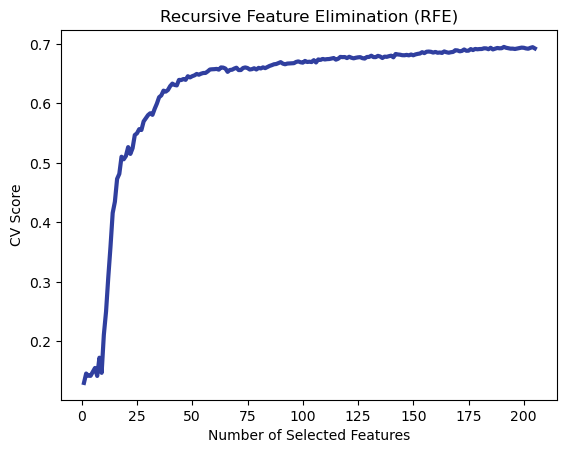

The optimal number of features: 191


In [50]:
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"], color='#303F9F', linewidth=3)
plt.xlabel("Number of Selected Features")
plt.ylabel("CV Score")
plt.title("Recursive Feature Elimination (RFE)")
plt.show()
print("The optimal number of features: {}".format(rfecv.n_features_))

Make a new DataFrame called "X_rfe" that contains selected features.

In [214]:
reduced_df_cor = np.array(reduced_df_cor, dtype=np.float32)

In [215]:
X_rfe = reduced_df_cor[:, rfecv.support_]

In [216]:
X_rfe.shape

(1400, 191)

In [201]:
estimator.fit(X_rfe, y_tr)

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000,
                          random_state=42, subsample=0.5)

In [202]:
y_pred_CV_GBR = cross_val_predict(estimator, X_rfe, y_tr, cv=cv, n_jobs=-1)

In [203]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.7

In [204]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.67

In [218]:
reduced_df_cor=x_tr_const_and_nearcont.drop(to_drop, axis=1)

In [244]:
feature_idx = rfecv.get_support()
feature_name_rfecv = reduced_df_cor.columns[feature_idx]
feature_name_rfecv

Index(['Bit_1', 'Bit_4', 'Bit_8', 'Bit_15', 'Bit_25', 'Bit_31', 'Bit_33',
       'Bit_36', 'Bit_41', 'Bit_42',
       ...
       'Bit_961', 'Bit_967', 'Bit_980', 'Bit_997', 'Bit_999', 'Bit_1009',
       'Bit_1010', 'Bit_1016', 'Bit_1017', 'Bit_1019'],
      dtype='object', length=191)

In [ ]:
df = pd.DataFrame(data[1:], columns=feature_name_rfecv)

In [248]:
type(feature_name_rfecv)

pandas.core.indexes.base.Index

In [255]:
from pathlib import Path

In [260]:
urls=list(feature_name_rfecv)

In [258]:
path = Path('feature_name_rfecv_MF.txt')

In [259]:
path.write_text('\n'.join(urls))

1510

# Prediction for test set's molecules

In [205]:
x_ts=desc_ts[feature_name_rfecv]

In [239]:
x_ts=desc_ts[proba]

In [206]:
y_ts = np.array(y_ts, dtype=np.float32)

In [207]:
y_pred_GBR = estimator.predict(x_ts)

In [208]:
Q2_TS = round(r2_score(y_ts, y_pred_GBR), 2)
Q2_TS

0.71

In [209]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_GBR)), 2)
RMSE_TS

0.66

# save the model to disk

In [210]:
pickle.dump(estimator, open('Models/Morgan_FP/HDAC3_GBR_MF_final_FS.pkl', 'wb'))

# load the model from disk

In [71]:
best_GBR = pickle.load(open('Models/Morgan_FP/HDAC3_GBR_MF_final_FS.pkl', 'rb'))

# 10. Y-randomization RF model

In [72]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_GBR, X_rfe, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  5.1min


True score =  0.69 
Y-randomization =  -0.33 
p-value =  0.0196


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 10.0min finished


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [75]:
neighbors_k= pairwise_distances(X_rfe, n_jobs=-1)
neighbors_k.sort(0)

In [76]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.732051,2.645751,2.645751,2.449490,2.449490,3.162278,2.236068,3.741657,4.000000,3.162278,...,3.162278,2.449490,2.449490,1.000000,1.414214,2.236068,2.236068,2.000000,4.358899,3.162278
2,2.000000,2.828427,3.162278,2.449490,2.828427,3.464102,3.872983,3.741657,4.358899,3.316625,...,4.123106,3.162278,2.828427,3.000000,1.732051,2.236068,2.645751,2.000000,4.795832,3.316625
3,2.000000,2.828427,3.605551,2.828427,4.123106,3.741657,3.872983,3.872983,4.472136,3.316625,...,4.242640,3.316625,2.828427,3.000000,2.449490,2.236068,3.162278,2.000000,5.000000,3.605551
4,2.236068,3.162278,4.123106,3.000000,4.242640,3.872983,4.000000,4.242640,4.582576,4.123106,...,4.358899,3.605551,3.000000,3.162278,2.449490,2.236068,3.316625,2.236068,5.099020,3.605551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,7.745967,7.937254,8.544003,7.874008,7.810250,8.485281,8.306623,7.745967,8.831760,8.306623,...,8.426149,8.426149,8.888194,8.831760,8.831760,9.055386,9.000000,9.110434,8.185352,9.000000
1396,7.810250,8.000000,8.602325,7.874008,7.874008,8.485281,8.366600,7.810250,8.831760,8.306623,...,8.485281,8.485281,8.944272,8.831760,8.888194,9.055386,9.000000,9.110434,8.185352,9.000000
1397,7.810250,8.000000,8.717798,7.937254,7.937254,8.485281,8.426149,7.810250,8.831760,8.306623,...,8.544003,8.544003,8.944272,8.888194,8.888194,9.110434,9.000000,9.110434,8.246211,9.000000
1398,7.874008,8.062258,8.717798,7.937254,8.000000,8.485281,8.485281,7.874008,8.831760,8.366600,...,8.602325,8.544003,9.000000,8.944272,9.000000,9.165152,9.055386,9.165152,8.366600,9.055386


In [77]:
similarity= neighbors_k

In [78]:
Dmean=np.mean(similarity[1,:])

In [79]:
round(Dmean, 2)

2.24

In [80]:
std=np.std(similarity[1,:])

In [81]:
round(std, 2)

1.08

In [82]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

2.78


In [107]:
x_ts=desc_ts[feature_name_rfecv]

In [92]:
neighbors_k_ts= pairwise_distances(X_rfe,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [93]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,341,342,343,344,345,346,347,348,349,350
0,0.000000,3.000000,5.385165,3.741657,2.236068,2.645751,2.449490,1.414214,3.464102,2.645751,...,1.732051,2.449490,2.236068,2.449490,2.449490,2.645751,2.236068,2.645751,3.605551,1.000000
1,2.236068,3.741657,5.656854,3.741657,2.828427,3.000000,4.000000,1.732051,3.605551,2.828427,...,2.000000,2.645751,2.449490,3.162278,2.828427,3.000000,2.449490,2.828427,3.605551,1.000000
2,2.236068,4.242641,5.656854,3.872983,3.162278,3.000000,4.242641,2.449490,3.741657,3.000000,...,2.449490,3.316625,2.828427,3.162278,3.162278,3.162278,3.000000,2.828427,3.741657,1.414214
3,2.236068,4.242641,5.656854,4.242641,3.162278,3.464102,4.358899,2.449490,4.795832,3.316625,...,2.449490,3.316625,2.828427,3.162278,3.162278,3.162278,3.000000,3.000000,3.872983,2.236068
4,2.645751,4.358899,5.744563,4.358899,4.123106,3.605551,4.582576,2.828427,4.898979,3.605551,...,2.645751,3.464102,3.000000,3.316625,3.316625,3.162278,3.316625,3.162278,4.123106,3.316625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,7.810250,7.874008,8.602325,9.110434,7.810250,8.000000,8.944272,7.874008,8.485281,8.000000,...,8.306624,8.246211,8.306624,9.165151,8.774964,9.219544,8.831761,8.831761,8.485281,8.306624
1396,7.810250,7.874008,8.602325,9.110434,7.810250,8.062258,8.944272,7.874008,8.485281,8.062258,...,8.306624,8.306624,8.366600,9.165151,8.831761,9.273618,8.888194,8.944272,8.485281,8.366600
1397,7.874008,8.000000,8.602325,9.219544,7.810250,8.185353,8.944272,8.000000,8.485281,8.185353,...,8.306624,8.306624,8.366600,9.219544,8.831761,9.273618,8.888194,8.944272,8.485281,8.366600
1398,7.874008,8.000000,8.602325,9.273618,7.874008,8.185353,9.000000,8.000000,8.602325,8.185353,...,8.306624,8.306624,8.366600,9.327379,8.888194,9.327379,8.944272,8.944272,8.485281,8.485281


In [94]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[0.    3.    5.385 3.742 2.236 2.646 2.449 1.414 3.464 2.646 3.162 2.646
 3.    2.828 3.    1.    1.    1.414 3.742 3.    2.236 3.742 3.    0.
 3.    1.    1.732 2.236 2.646 2.236 3.317 2.    3.606 3.317 2.828 0.
 3.162 2.236 2.449 2.236 2.828 3.464 3.464 3.742 2.646 3.464 3.606 3.
 1.    1.414 1.732 3.464 3.162 2.236 1.414 3.606 1.414 2.828 2.828 2.828
 2.    3.    2.828 3.873 3.873 1.732 4.    2.646 1.    4.123 3.742 2.449
 2.236 2.828 0.    0.    2.    2.449 3.    3.464 2.236 2.236 2.    2.828
 2.646 1.414 2.449 1.732 2.    2.828 2.449 4.123 3.873 2.    0.    3.317
 1.414 2.    0.    2.    4.123 1.414 2.449 0.    2.    2.646 3.    0.
 2.646 1.    2.236 1.732 1.414 2.236 4.    1.    2.    0.    2.449 2.
 3.606 1.732 3.    3.    3.162 2.449 3.162 2.449 1.732 3.742 1.414 2.236
 1.414 3.    1.414 1.732 2.    3.162 3.606 1.    4.583 1.    2.646 1.732
 2.236 2.646 1.414 2.646 2.    4.472 1.    3.162 2.646 1.732 0.    1.732
 1.732 1.    3.    2.236 1.    2.449 1.732 2.646 0.    1.732 3.   

In [95]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True False False False  True  True  True  True False  True False  True
 False False False  True  True  True False False  True False False  True
 False  True  True  True  True  True False  True False False False  True
 False  True  True  True False False False False  True False False False
  True  True  True False False  True  True False  True False False False
  True False False False False  True False  True  True False False  True
  True False  True  True  True  True False False  True  True  True False
  True  True  True  True  True False  True False False  True  True False
  True  True  True  True False  True  True  True  True  True False  True
  True  True  True  True  True  True False  True  True  True  True  True
 False  True False False False  True False  True  True False  True  True
  True False  True  True  True False False  True False  True  True  True
  True  True  True  True  True False  True False  True  True  True  True
  True  True False  True  True  True  True  True  T

In [96]:
print("Coverage = ", sum(cpd_AD) / len(cpd_AD))

Coverage =  0.6752136752136753


In [97]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  0   4   5   6   7   9  11  15  16  17  20  23  25  26  27  28  29  31
  35  37  38  39  44  48  49  50  53  54  56  60  65  67  68  71  72  74
  75  76  77  80  81  82  84  85  86  87  88  90  93  94  96  97  98  99
 101 102 103 104 105 107 108 109 110 111 112 113 115 116 117 118 119 121
 125 127 128 130 131 132 134 135 136 139 141 142 143 144 145 146 147 148
 150 152 153 154 155 156 157 159 160 161 162 163 164 165 167 168 169 170
 171 172 173 174 176 178 180 183 184 185 187 188 190 191 192 193 195 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 220 221 222 223 226 227 228 230 232 233 237 238 239 240 242
 244 246 247 248 250 251 252 253 254 255 256 257 258 259 260 263 264 265
 266 267 268 269 270 272 275 277 281 282 283 284 286 289 290 291 292 294
 299 300 301 303 304 306 307 311 312 313 315 316 317 318 319 321 323 324
 325 326 327 329 331 332 333 334 335 336 338 339 341 342 343 344 345 346
 347 348 35

In [98]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [99]:
y_pred_GBR_ad=list(y_pred_GBR)

In [100]:
y_pred_GBR_ad[:] = [x for i,x in enumerate(y_pred_GBR_ad) if i not in out_Ad]

In [101]:
len(y_pred_GBR_ad)

237

In [102]:
y_ts_ad=list(y_ts)

In [103]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [104]:
len(y_ts_ad)

237

In [195]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_GBR_ad), 2)
Q2_TS

0.76

In [196]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_GBR_ad)), 2)
RMSE_TS

0.58

# SVM model building and validation

In [153]:
from sklearn.svm import SVR

In [154]:
param_grid = {"C": [10 ** i for i in range(0, 5)],
              "gamma": [10 ** i for i in range(-6, 0)]}

In [155]:
seed = 42
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [156]:
svm = GridSearchCV(SVR(C=1.0, epsilon=0.2), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [157]:
svm.fit(X_rfe, y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVR(epsilon=0.2), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000, 10000],
                         'gamma': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]},
             verbose=1)

In [158]:
svm.best_params_
best_svm = svm.best_estimator_

In [159]:
svm.best_params_

{'C': 10, 'gamma': 0.01}

In [160]:
y_pred_CV_svm = cross_val_predict(best_svm, X_rfe, y_tr, cv=cv)

In [161]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_svm), 2)
Q2_CV

0.67

In [162]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_svm)), 2)
RMSE_CV

0.7

#  Prediction for test set's molecules

In [163]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [164]:
y_pred_svm = best_svm.predict(x_ts)

In [165]:
Q2_TS = round(r2_score(y_ts, y_pred_svm), 2)
Q2_TS

0.63

In [166]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_svm)), 2)
RMSE_TS

0.75

save the model to disk

In [167]:
pickle.dump(best_svm, open('Models/Morgan_FP/HDAC3_SVM_Morgan_FP.pkl', 'wb'))

load the model from disk

In [168]:
best_svm = pickle.load(open('Models/Morgan_FP/HDAC3_SVM_Morgan_FP.pkl', 'rb'))

# 10. Y-randomization SVM model

In [169]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_svm, X_rfe, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(3),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.2s


True score =  0.663 
Y-randomization =  -0.2 
p-value =  0.0196


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.6s finished


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [170]:
neighbors_k= pairwise_distances(X_rfe, n_jobs=-1)
neighbors_k.sort(0)

In [171]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.732051,2.645751,2.645751,2.449490,2.449490,3.162278,2.236068,3.741657,4.000000,3.162278,...,3.162278,2.449490,2.449490,1.000000,1.414214,2.236068,2.236068,2.000000,4.358899,3.162278
2,2.000000,2.828427,3.162278,2.449490,2.828427,3.464102,3.872983,3.741657,4.358899,3.316625,...,4.123106,3.162278,2.828427,3.000000,1.732051,2.236068,2.645751,2.000000,4.795832,3.316625
3,2.000000,2.828427,3.605551,2.828427,4.123106,3.741657,3.872983,3.872983,4.472136,3.316625,...,4.242640,3.316625,2.828427,3.000000,2.449490,2.236068,3.162278,2.000000,5.000000,3.605551
4,2.236068,3.162278,4.123106,3.000000,4.242640,3.872983,4.000000,4.242640,4.582576,4.123106,...,4.358899,3.605551,3.000000,3.162278,2.449490,2.236068,3.316625,2.236068,5.099020,3.605551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,7.745967,7.937254,8.544003,7.874008,7.810250,8.485281,8.306623,7.745967,8.831760,8.306623,...,8.426149,8.426149,8.888194,8.831760,8.831760,9.055386,9.000000,9.110434,8.185352,9.000000
1396,7.810250,8.000000,8.602325,7.874008,7.874008,8.485281,8.366600,7.810250,8.831760,8.306623,...,8.485281,8.485281,8.944272,8.831760,8.888194,9.055386,9.000000,9.110434,8.185352,9.000000
1397,7.810250,8.000000,8.717798,7.937254,7.937254,8.485281,8.426149,7.810250,8.831760,8.306623,...,8.544003,8.544003,8.944272,8.888194,8.888194,9.110434,9.000000,9.110434,8.246211,9.000000
1398,7.874008,8.062258,8.717798,7.937254,8.000000,8.485281,8.485281,7.874008,8.831760,8.366600,...,8.602325,8.544003,9.000000,8.944272,9.000000,9.165152,9.055386,9.165152,8.366600,9.055386


In [172]:
similarity= neighbors_k

In [173]:
Dmean=np.mean(similarity[1,:])

In [174]:
round(Dmean, 2)

2.24

In [175]:
std=np.std(similarity[1,:])

In [176]:
round(std, 2)

1.08

In [177]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

2.78


In [178]:
x_ts=desc_ts[feature_name_rfecv]

In [179]:
neighbors_k_ts= pairwise_distances(X_rfe,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [180]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,341,342,343,344,345,346,347,348,349,350
0,0.000000,3.000000,5.385165,3.741657,2.236068,2.645751,2.449490,1.414214,3.464102,2.645751,...,1.732051,2.449490,2.236068,2.449490,2.449490,2.645751,2.236068,2.645751,3.605551,1.000000
1,2.236068,3.741657,5.656854,3.741657,2.828427,3.000000,4.000000,1.732051,3.605551,2.828427,...,2.000000,2.645751,2.449490,3.162278,2.828427,3.000000,2.449490,2.828427,3.605551,1.000000
2,2.236068,4.242641,5.656854,3.872983,3.162278,3.000000,4.242641,2.449490,3.741657,3.000000,...,2.449490,3.316625,2.828427,3.162278,3.162278,3.162278,3.000000,2.828427,3.741657,1.414214
3,2.236068,4.242641,5.656854,4.242641,3.162278,3.464102,4.358899,2.449490,4.795832,3.316625,...,2.449490,3.316625,2.828427,3.162278,3.162278,3.162278,3.000000,3.000000,3.872983,2.236068
4,2.645751,4.358899,5.744563,4.358899,4.123106,3.605551,4.582576,2.828427,4.898979,3.605551,...,2.645751,3.464102,3.000000,3.316625,3.316625,3.162278,3.316625,3.162278,4.123106,3.316625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,7.810250,7.874008,8.602325,9.110434,7.810250,8.000000,8.944272,7.874008,8.485281,8.000000,...,8.306624,8.246211,8.306624,9.165151,8.774964,9.219544,8.831761,8.831761,8.485281,8.306624
1396,7.810250,7.874008,8.602325,9.110434,7.810250,8.062258,8.944272,7.874008,8.485281,8.062258,...,8.306624,8.306624,8.366600,9.165151,8.831761,9.273618,8.888194,8.944272,8.485281,8.366600
1397,7.874008,8.000000,8.602325,9.219544,7.810250,8.185353,8.944272,8.000000,8.485281,8.185353,...,8.306624,8.306624,8.366600,9.219544,8.831761,9.273618,8.888194,8.944272,8.485281,8.366600
1398,7.874008,8.000000,8.602325,9.273618,7.874008,8.185353,9.000000,8.000000,8.602325,8.185353,...,8.306624,8.306624,8.366600,9.327379,8.888194,9.327379,8.944272,8.944272,8.485281,8.485281


In [181]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[0.    3.    5.385 3.742 2.236 2.646 2.449 1.414 3.464 2.646 3.162 2.646
 3.    2.828 3.    1.    1.    1.414 3.742 3.    2.236 3.742 3.    0.
 3.    1.    1.732 2.236 2.646 2.236 3.317 2.    3.606 3.317 2.828 0.
 3.162 2.236 2.449 2.236 2.828 3.464 3.464 3.742 2.646 3.464 3.606 3.
 1.    1.414 1.732 3.464 3.162 2.236 1.414 3.606 1.414 2.828 2.828 2.828
 2.    3.    2.828 3.873 3.873 1.732 4.    2.646 1.    4.123 3.742 2.449
 2.236 2.828 0.    0.    2.    2.449 3.    3.464 2.236 2.236 2.    2.828
 2.646 1.414 2.449 1.732 2.    2.828 2.449 4.123 3.873 2.    0.    3.317
 1.414 2.    0.    2.    4.123 1.414 2.449 0.    2.    2.646 3.    0.
 2.646 1.    2.236 1.732 1.414 2.236 4.    1.    2.    0.    2.449 2.
 3.606 1.732 3.    3.    3.162 2.449 3.162 2.449 1.732 3.742 1.414 2.236
 1.414 3.    1.414 1.732 2.    3.162 3.606 1.    4.583 1.    2.646 1.732
 2.236 2.646 1.414 2.646 2.    4.472 1.    3.162 2.646 1.732 0.    1.732
 1.732 1.    3.    2.236 1.    2.449 1.732 2.646 0.    1.732 3.   

In [182]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True False False False  True  True  True  True False  True False  True
 False False False  True  True  True False False  True False False  True
 False  True  True  True  True  True False  True False False False  True
 False  True  True  True False False False False  True False False False
  True  True  True False False  True  True False  True False False False
  True False False False False  True False  True  True False False  True
  True False  True  True  True  True False False  True  True  True False
  True  True  True  True  True False  True False False  True  True False
  True  True  True  True False  True  True  True  True  True False  True
  True  True  True  True  True  True False  True  True  True  True  True
 False  True False False False  True False  True  True False  True  True
  True False  True  True  True False False  True False  True  True  True
  True  True  True  True  True False  True False  True  True  True  True
  True  True False  True  True  True  True  True  T

In [183]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.68


In [184]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  0   4   5   6   7   9  11  15  16  17  20  23  25  26  27  28  29  31
  35  37  38  39  44  48  49  50  53  54  56  60  65  67  68  71  72  74
  75  76  77  80  81  82  84  85  86  87  88  90  93  94  96  97  98  99
 101 102 103 104 105 107 108 109 110 111 112 113 115 116 117 118 119 121
 125 127 128 130 131 132 134 135 136 139 141 142 143 144 145 146 147 148
 150 152 153 154 155 156 157 159 160 161 162 163 164 165 167 168 169 170
 171 172 173 174 176 178 180 183 184 185 187 188 190 191 192 193 195 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 220 221 222 223 226 227 228 230 232 233 237 238 239 240 242
 244 246 247 248 250 251 252 253 254 255 256 257 258 259 260 263 264 265
 266 267 268 269 270 272 275 277 281 282 283 284 286 289 290 291 292 294
 299 300 301 303 304 306 307 311 312 313 315 316 317 318 319 321 323 324
 325 326 327 329 331 332 333 334 335 336 338 339 341 342 343 344 345 346
 347 348 35

In [185]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [186]:
y_pred_svm_ad=list(y_pred_svm)

In [187]:
y_pred_svm_ad[:] = [x for i,x in enumerate(y_pred_svm_ad) if i not in out_Ad]

In [188]:
len(y_pred_svm_ad)

237

In [189]:
y_ts_ad=list(y_ts)

In [190]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [191]:
len(y_ts_ad)

237

In [192]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_svm_ad), 2)
Q2_TS

0.7

In [193]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_svm_ad)), 2)
RMSE_TS

0.65